<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data-Augmentation/Analysis" data-toc-modified-id="Data-Augmentation/Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Augmentation/Analysis</a></span></li><li><span><a href="#Dataloader-creation-and-test" data-toc-modified-id="Dataloader-creation-and-test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataloader creation and test</a></span></li><li><span><a href="#Model-creation" data-toc-modified-id="Model-creation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model creation</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Training</a></span><ul class="toc-item"><li><span><a href="#Model-Testing" data-toc-modified-id="Model-Testing-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Model Testing</a></span></li></ul></li></ul></div>

**GET DATA**

Summary of this notebook: ...

Definition of Done: ...

# Imports


In [1]:
import os
from os import path
import sys
import math
import cv2 # Read raw image
import glob
import random
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy import ndimage # For rotation task or
import imutils
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
from skimage.transform import resize
from pprint import pprint
import tqdm

import tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils import data_utils
from tensorflow.keras.preprocessing.image import Iterator
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, AveragePooling2D, MaxPooling2D, Reshape, Conv2DTranspose, ZeroPadding2D, Add
from tensorflow.keras.layers import Activation, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import PReLU

sys.path.append("/home/satyarth934/code/FDL_2020/training_scripts")
import utils

# Check to see if GPU is being used
print(tensorflow.test.gpu_device_name())
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/device:GPU:0
Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Num GPUs Available:  2


In [2]:
DATA_PATH = "/home/satyarth934/data/modis_data_products/*/array_3bands_normalized/448/*"

img_paths = glob.glob(DATA_PATH)
train_test_split = 0.8
X_test_paths = img_paths[int(train_test_split * len(img_paths)):]
print(len(X_test_paths))

dims = (448, 448, 3)

# Loading Data
X_test = utils.getData(X_test_paths, dims)
X_test = utils.normalize(X_test)

146


In [3]:
# nan_val = utils.nansInData(X_test)
# plt.scatter(np.arange(1,len(nan_val)+1), nan_val)

# print("Usable:", len([v for v in nan_val if v<20000]))

# print("Mahashay:", [(i, v) for i, v in enumerate(nan_val) if v>500000])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


attempts: 4.0
attempts: 2.7022977022977024
attempts: 2.7031484257871066
attempts: 2.738587137620793
attempts: 2.741064733816546
attempts: 2.7534493101379725
attempts: 2.745875687385436
attempts: 2.748107413226682
attempts: 2.743094613173353
attempts: 2.7434729474502833
attempts: 2.740875912408759
attempts: 2.7327061176256704
attempts: 2.731730689109241
attempts: 2.7344435043458195
attempts: 2.7253410470680666
attempts: 2.7281181254583027
attempts: 2.7260483719767516
attempts: 2.7262513969766484
attempts: 2.724515304705294
attempts: 2.727356454923425
attempts: 2.7255887205639717
attempts: 2.725727346316842
attempts: 2.7235352938502797
attempts: 2.7197730533455067
attempts: 2.721469938752552
attempts: 2.7209711611535536
attempts: 2.7222222222222223
attempts: 2.723788007851561
attempts: 2.725045534088068
attempts: 2.724371573394021
attempts: 2.7229259024699175
attempts: 2.7232024773394405
attempts: 2.723493015843255
attempts: 2.725462864761674
attempts: 2.7263315784829856
attempts: 2.7250

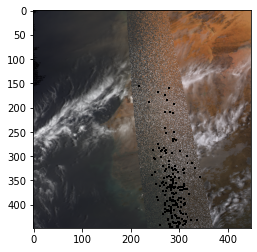

In [4]:
# 45 pixels: radius of the locality
# plt.imshow(X_test[10])
# plt.show()

import random
from multiprocessing import Pool


def getClosest(pt, options):
    x,y = pt
    min_val = -9999
    min_pt = options[0]
    for o in options:
        sse = np.sum(np.square(np.array(pt) - np.array(o)))
        if sse < min_val:
            min_val = se
            min_pt = o
    
    return min_pt


N = 2
radius = 85

# local region
(x,y,z) = np.where(np.isnan(X_test[10]))

# nan value indices
nan_idxs = [_ for _ in zip(x,y)]
nan_idxs = list(set(nan_idxs))

attempts = 0

clone = np.copy(X_test[10])

for i, item in enumerate(tqdm.tqdm_notebook(nan_idxs)):
    x,y = item
    # region
    xtl, xtr = max(0, x - radius), min(X_test[10].shape[1], x + radius)
    ytl, ytr = max(0, y - radius), min(X_test[10].shape[1], y + radius)
    
    random_idxs = []
    counter = 0
    att2 = 0
    flag = 0
    while counter < N:
        if att2 > N * 10:
            flag = 1
            break
        att2 += 1
        
        attempts += 1
        random_idx = np.random.randint(xtl, xtr), np.random.randint(ytl, ytr)
#         random_idx = (1,2)
        if np.sum(np.isnan(X_test[10][random_idx[0], random_idx[1],:])) > 0:
            continue
        random_idxs.append(random_idx)
        counter += 1
    
    if i%1000 == 0:
        print("attempts:", attempts / ((i+1) * N))
    
    if(flag==1):
        continue

#     closest_x, closest_y = random_idx
#     print("===>>", *zip(random_idx[0], random_idx[1]))
    closest_x, closest_y = getClosest((x,y), random_idxs)
#     print(x_rand)
#     print(y_rand)
#     print(closest_x, closest_y)
#     print("------")
    clone[x,y,:] = X_test[10][closest_x,closest_y,:]

plt.imshow(clone)
# plt.savefig("n%drad%dA3.png" % (N, radius))
plt.show()

In [ ]:
img1 = plt.imread('n3rad45.png')
img2 = plt.imread('n1rad45.png')

print(np.sum(img1 - img2))

In [ ]:
[(i,j) for i in range(5) for j in range(3)]

In [ ]:
s1 = [(1,2,4), (5,6,2), (9,5,8), (4,0,6)]
s2 = [(7,4,6), (4,0,6), (1,4,6)]

print(set(s1) - set(s2))
print(list(set(s1) - set(s2)))

# Dataloader creation and test

In [ ]:
# NEW MODIS DATASET

# img_paths = glob.glob("/home/satyarth934/data/modis_data_products/*/array_3bands_normalized/448/*")
# img_paths = glob.glob("/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/mean_stdev_removed/*") # <- needs to be normalized
img_paths = glob.glob("/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/median_removed/*") # <- needs to be normalized
img_paths = sorted(img_paths)
print("len(img_paths):", len(img_paths))
# random.shuffle(img_paths)

train_test_split = 0.8
X_train_paths = img_paths[:int(train_test_split*len(img_paths))]
X_test_paths = img_paths[int(train_test_split*len(img_paths)):]

dims=(448,448,3)

# Loading Training Data
X_train = np.empty((len(X_train_paths),*dims))
for i, p in enumerate(X_train_paths):
    X_train[i,:,:,:] = np.load(p)

# Loading Testing Data
X_test = np.empty((len(X_test_paths),*dims))
for i, p in enumerate(X_test_paths):
    X_test[i,:,:,:] = np.load(p)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

# To check what percentage of pixels are 'nan'
print(np.sum(np.isnan(X_train)) / np.prod(X_train.shape))
print(np.sum(np.isnan(X_test)) / np.prod(X_test.shape))

# Checking min max to see if normalization is needed or not
print("Before normalization")
print(np.nanmin(X_train), np.nanmax(X_train))
print(np.nanmin(X_test), np.nanmax(X_test))

# Normalize Inputs
def normalize(mat):
    valid_cells = np.invert(np.isnan(mat))
    normalized = np.subtract(mat, np.nanmin(mat), where=valid_cells) / (np.nanmax(mat) - np.nanmin(mat))
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

# Checking min max after normalization 
print("After normalization")
print(np.nanmin(X_train), np.nanmax(X_train))
print(np.nanmin(X_test), np.nanmax(X_test))

# Set nan values to 0
# X_train[np.isnan(X_train)] = 0.0
# X_test[np.isnan(X_test)] = 0.0

In [ ]:
# NEW MODIS DATASET

img_paths_orig = glob.glob("/home/satyarth934/data/modis_data_products/terra/array_3bands_normalized/448/*")
img_paths_orig = sorted(img_paths_orig)
# img_paths_orig = glob.glob("/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/mean_stdev_removed/*") # <- needs to be normalized
# img_paths_orig = glob.glob("/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/median_removed/*") # <- needs to be normalized
print("len(img_paths_orig):", len(img_paths_orig))
# random.shuffle(img_paths_orig)

train_test_split = 0.8
X_train_paths_orig = img_paths_orig[:int(train_test_split*len(img_paths_orig))]
X_test_paths_orig = img_paths_orig[int(train_test_split*len(img_paths_orig)):]

# np.save(PATH_LIST_LOCATION, [X_train_paths_orig, X_test_paths_orig])

dims=(448,448,3)

# Loading Training Data
X_train_orig = np.empty((len(X_train_paths_orig),*dims))
for i, p in enumerate(X_train_paths_orig):
    X_train_orig[i,:,:,:] = np.load(p)

# Loading Testing Data
X_test_orig = np.empty((len(X_test_paths_orig),*dims))
for i, p in enumerate(X_test_paths_orig):
    X_test_orig[i,:,:,:] = np.load(p)

print("X_train_orig:", X_train_orig.shape)
print("X_test_orig:", X_test_orig.shape)

# To check what percentage of pixels are 'nan'
print(np.sum(np.isnan(X_train_orig)) / np.prod(X_train_orig.shape))
print(np.sum(np.isnan(X_test_orig)) / np.prod(X_test.shape))

# Checking min max to see if normalization is needed or not
print("Before normalization")
print(np.nanmin(X_train_orig), np.nanmax(X_train_orig))
print(np.nanmin(X_test_orig), np.nanmax(X_test_orig))

# Normalize Inputs
def normalize(mat):
    valid_cells = np.invert(np.isnan(mat))
    normalized = np.subtract(mat, np.nanmin(mat), where=valid_cells) / (np.nanmax(mat) - np.nanmin(mat))
    return normalized

X_train_orig = normalize(X_train_orig)
X_test_orig = normalize(X_test_orig)

# Checking min max after normalization 
print("After normalization")
print(np.nanmin(X_train_orig), np.nanmax(X_train_orig))
print(np.nanmin(X_test_orig), np.nanmax(X_test_orig))

# Set nan values to 0
# X_train[np.isnan(X_train)] = 0.0
# X_test[np.isnan(X_test)] = 0.0

In [ ]:
nan_idxsprint(X_train.shape)
print(X_train_orig.shape)
r = 10
c = 2
fig, axs = plt.subplots(nrows=r, ncols=c, figsize=(20,60))
for i in range(r):
    axs[i, 0].imshow(X_train_orig[10+i,:,:,:])
    axs[i, 1].imshow(X_train[10+i,:,:,:])

fig.savefig("orig_vs_median.png")